In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install torchaudio
!pip install PyDrive
!pip install soundfile

     |████████████████████████████████| 3.2MB 9.2MB/s 


In [4]:
import torch
import torchaudio

In [5]:
! git clone https://github.com/facebookresearch/CPC_audio.git

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [6]:
%cd /content/CPC_audio
!python setup.py develop

/content/CPC_audio
Compiling cpc/eval/ABX/dtw.pyx because it changed.
[1/1] Cythonizing cpc/eval/ABX/dtw.pyx
running develop
running egg_info
creating CPC_audio.egg-info
writing CPC_audio.egg-info/PKG-INFO
writing dependency_links to CPC_audio.egg-info/dependency_links.txt
writing top-level names to CPC_audio.egg-info/top_level.txt
writing manifest file 'CPC_audio.egg-info/SOURCES.txt'
writing manifest file 'CPC_audio.egg-info/SOURCES.txt'
running build_ext
building 'cpc.eval.ABX.dtw' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/cpc
creating build/temp.linux-x86_64-3.6/cpc/eval
creating build/temp.linux-x86_64-3.6/cpc/eval/ABX
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/include/python3.6m -c cpc/eval/ABX/dtw.c -o build/temp.linux-x86_64-3.6/cpc/eval/ABX/

# Fine tuning

## Exercice 1 : Phone separability with aligned phonemes.

One option to evaluate the quality of the features trained with CPC can be to check if they can be used to recognize phonemes. 
To do so, we can fine-tune a pre-trained model using a limited amount of labelled speech data.
We are going to start with a simple evaluation setting where we have the phone labels for each timestep corresponding to a CPC feature.

We will work with a model already pre-trained on English data. As far as the fine-tuning dataset is concerned, we will use a 1h subset of [librispeech-100](http://www.openslr.org/12/). 

In [7]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data
!ls checkpoint_data

--2020-07-04 22:44:12--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt’

checkpoint_30.pt    100%[===================>] 108.34M  10.5MB/s    in 12s     

2020-07-04 22:44:25 (9.29 MB/s) - ‘checkpoint_data/checkpoint_30.pt’ saved [113599715/113599715]

--2020-07-04 22:44:27--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, 

In [17]:
# Several functions that will be necessary to load the data later
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from cpc.dataset import findAllSeqs, AudioBatchData, parseSeqLabels
SIZE_WINDOW = 20480
BATCH_SIZE=8
def load_dataset(path_dataset, file_extension='.wav', phone_label_dict=None):
  data_list, speakers = findAllSeqs(path_dataset, extension=file_extension)
  dataset = AudioBatchData(path_dataset, SIZE_WINDOW, data_list, phone_label_dict, len(speakers))
  return dataset

In [14]:
%cd /content/CPC_audio
from cpc.dataset import parseSeqLabels
from cpc.feature_loader import loadModel

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
label_dict, N_PHONES = parseSeqLabels('/content/drive/My Drive/speech Recognition Data- Final project/data/all_sessions.txt')
dataset_train = load_dataset('/content/drive/My Drive/speech Recognition Data- Final project/data/Train', file_extension='.wav', phone_label_dict=label_dict)
dataset_val = load_dataset('/content/drive/My Drive/speech Recognition Data- Final project/data/Val', file_extension='.wav', phone_label_dict=label_dict)
data_loader_train = dataset_train.getDataLoader(BATCH_SIZE, "speaker", True)
data_loader_val = dataset_val.getDataLoader(BATCH_SIZE, "sequence", False)

8it [00:00, 532.78it/s]

/content/CPC_audio
Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt
Saved cache file at /content/drive/My Drive/speech Recognition Data- Final project/data/Train/_seqs_cache.txt


Checking length...


375it [00:00, 139599.18it/s]


Done, elapsed: 0.409 seconds
Scanned 375 sequences in 0.41 seconds
1 chunks computed
Joining pool


4it [00:00, 134.83it/s]

Joined process, elapsed=1.016 secs
Saved cache file at /content/drive/My Drive/speech Recognition Data- Final project/data/Val/_seqs_cache.txt


Checking length...


150it [00:00, 75773.29it/s]


Done, elapsed: 0.257 seconds
Scanned 150 sequences in 0.26 seconds
1 chunks computed
Joining pool
Joined process, elapsed=0.579 secs


Then we will use a simple linear classifier to recognize the phonemes from the features produced by ```cpc_model```. 

### a) Build the phone classifier 

Design a class of linear classifiers, ```PhoneClassifier``` that will take as input a batch of sequences of CPC features and output a score vector for each phoneme

In [15]:
class PhoneClassifier(torch.nn.Module):

  def __init__(self,
               input_dim : int,
               n_phones : int):
    super(PhoneClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, n_phones)
    

  def forward(self, x):
    return self.linear(x)

Our phone classifier will then be:

In [18]:
phone_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_PHONES).to(device)

### b - What would be the correct loss criterion for this task ?



In [19]:
loss_criterion = torch.nn.CrossEntropyLoss()

To perform the fine-tuning, we will also need an optimization function.

We will use an [Adam optimizer ](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [20]:
parameters = list(phone_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

You might also want to perform this training while freezing the weights of the ```cpc_model```. Indeed, if the pre-training was good enough, then ```cpc_model``` phonemes representation should be linearly separable. In this case the optimizer should be defined like this:

In [21]:
optimizer_frozen = torch.optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)

### c- Now let's build a training loop. 
Complete the function ```train_one_epoch``` below.



In [22]:
def train_one_epoch(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader, 
                    optimizer):

  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):
    # Each batch is represented by a Tuple of vectors:
    # sequence of size : N x 1 x T
    # label of size : N x T
    # 
    # With :
    # - N number of sequence in the batch
    # - T size of each sequence
    sequence, label = full_data
    
    

    bs = len(sequence)
    seq_len = label.size(1)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(sequence.to(device),label.to(device))

    scores = phone_classifier(context_out)

    scores = scores.permute(0,2,1)
    loss = loss_criterion(scores,label.to(device))
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
    correct_labels = scores.argmax(1)
    avg_accuracy += ((label==correct_labels.cpu()).float()).mean(1).sum().item()
  avg_loss/=n_items
  avg_accuracy/=n_items
  return avg_loss, avg_accuracy

Don't forget to test it !

In [23]:
avg_loss, avg_accuracy = train_one_epoch(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer_frozen)

In [24]:
avg_loss, avg_accuracy

(3.85103612475925, 0.018337673611111112)

### d- Build the validation loop

In [25]:
def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):
  
  cpc_model.eval()
  phone_classifier.eval()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):
      # Each batch is represented by a Tuple of vectors:
      # sequence of size : N x 1 x T
      # label of size : N x T
      # 
      # With :
      # - N number of sequence in the batch
      # - T size of each sequence
      sequence, label = full_data
      bs = len(sequence)
      seq_len = label.size(1)
      context_out, enc_out, _ = cpc_model(sequence.to(device),label.to(device))
      scores = phone_classifier(context_out)
      scores = scores.permute(0,2,1)
      loss = loss_criterion(scores,label.to(device))
      avg_loss+=loss.item()*bs
      n_items+=bs
      correct_labels = scores.argmax(1)
      avg_accuracy += ((label==correct_labels.cpu()).float()).mean(1).sum().item()
  avg_loss/=n_items
  avg_accuracy/=n_items
  return avg_loss, avg_accuracy

### e- Run everything

Test this functiion with both ```optimizer``` and ```optimizer_frozen```.

In [30]:
def run(cpc_model, 
        phone_classifier, 
        loss_criterion, 
        data_loader_train, 
        data_loader_val, 
        optimizer,
        n_epoch):
    
    losses_train = []
    losses_validation = []
    for epoch in range(n_epoch):
        print(f"Running epoch {epoch + 1} / {n_epoch}")
        loss_train, acc_train = train_one_epoch(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
        losses_train.append(loss_train)
        print("-------------------")
        print(f"Training dataset :")
        print(f"Average loss : {loss_train}. Average accuracy {acc_train}")

        print("-------------------")
        print("Validation dataset")
        loss_val, acc_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
        losses_validation.append(loss_val)
        print(f"Average loss : {loss_val}. Average accuracy {acc_val}")
        print("-------------------")
        print()
    return losses_train, losses_validation 

In [31]:
losses_train, losses_validation = run(cpc_model, phone_classifier,loss_criterion,data_loader_train,data_loader_val,optimizer_frozen,n_epoch=30)

Running epoch 1 / 30
-------------------
Training dataset :
Average loss : 3.1336056921217175. Average accuracy 0.14393446180555555
-------------------
Validation dataset
Average loss : 3.1131326258182526. Average accuracy 0.150390625
-------------------

Running epoch 2 / 30
-------------------
Training dataset :
Average loss : 3.1325244771109686. Average accuracy 0.1444769965277778
-------------------
Validation dataset
Average loss : 3.11051744222641. Average accuracy 0.150390625
-------------------

Running epoch 3 / 30
-------------------
Training dataset :
Average loss : 3.127566032939487. Average accuracy 0.14453125
-------------------
Validation dataset
Average loss : 3.107504278421402. Average accuracy 0.150634765625
-------------------

Running epoch 4 / 30
-------------------
Training dataset :
Average loss : 3.125495274861654. Average accuracy 0.1454535590277778
-------------------
Validation dataset
Average loss : 3.103110134601593. Average accuracy 0.151611328125
--------

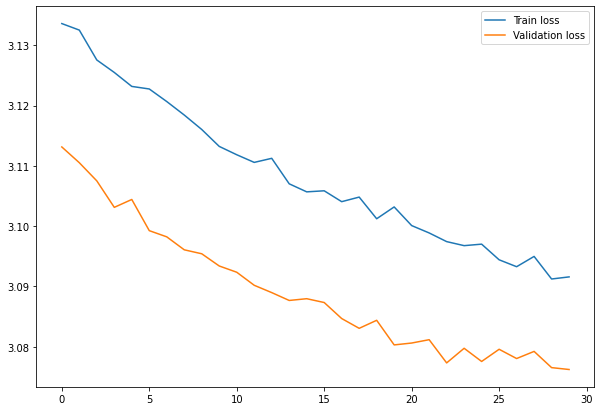

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(losses_train, label='Train loss')
plt.plot(losses_validation, label='Validation loss')
plt.legend()
plt.show()

## Exercise 2 : Phone separability without alignment (PER)

Aligned data are very practical, but un real life they are rarely available. That's why in this excercise we will consider a fine-tuning with non-aligned phonemes.

The model, the optimizer and the phone classifier will stay the same. However, we will replace our phone criterion with a [CTC loss](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). 

In [33]:
loss_ctc = torch.nn.CTCLoss()

In [44]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        phone_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = phone_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  phone_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = phone_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(cpc_model, 
            phone_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            n_epoch):
    train_loss = []
    val_loss = []
    for epoch in range(n_epoch):

        print(f"Running epoch {epoch + 1} / {n_epoch}")
        loss_train = train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
        train_loss.append(loss_train)
        print("-------------------")
        print(f"Training dataset :")
        print(f"Average loss : {loss_train}.")

        print("-------------------")
        print("Validation dataset")
        loss_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
        val_loss.append(loss_val)
        print(f"Average loss : {loss_val}")
        print("-------------------")
        print()
    return train_loss, val_loss 

### b- Evaluation: the Phone Error Rate (PER)

In order to compute the similarity between two sequences, we can use the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This distance estimates the minimum number of insertion, deletion and addition to move from one sequence to another. If we normalize this distance by the number of characters in the reference sequence we get the Phone Error Rate (PER).

This value can be interpreted as :
\\[  PER = \frac{S + D + I}{N} \\]

Where:


*   N is the number of characters in the reference
*   S is the number of substitutiion
*   I in the number of insertion
*   D in the number of deletion

For the best possible alignment of the two sequences.



In [36]:
import numpy as np

def get_PER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1,m+1))
  for i in range(1,n+1):
    D[i,0] = D[i-1,0]+1
  for j in range(1,m+1):
    D[0,j] = D[0,j-1]+1
  
  ### TODO compute the alignment

  for i in range(1,n+1):
    for j in range(1,m+1):
      D[i,j] = min(
          D[i-1,j]+1,
          D[i-1,j-1]+1,
          D[i,j-1]+1,
          D[i-1,j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

  #return PER

You can test your function below:

In [37]:
ref_seq = [0, 1, 1, 2, 0, 2, 2]
pred_seq = [1, 1, 2, 2, 0, 0]

expected_PER = 4. / 7.
print(get_PER_sequence(ref_seq, pred_seq) == expected_PER)

True


## c- Evaluating the PER of your model on the test dataset

Evaluate the PER on the validation dataset. Please notice that you should usually use a separate dataset, called the dev dataset, to perform this operation. However for the sake of simplicity we will work with validation data in this exercise.

In [38]:
import progressbar
from multiprocessing import Pool

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_per(test_dataloader,
            cpc_model,
            phone_classifier):

  downsampling_factor = 160
  cpc_model.eval()
  phone_classifier.eval()

  avgPER = 0
  nItems = 0 

  print("Starting the PER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)

    with torch.no_grad():
      
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
        phone_classifier(c_feature), dim=2).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()

        bs = c_feature.size(0)
        data_per = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_per = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]

        with Pool(bs) as p:
            poolData = p.starmap(get_PER_sequence, data_per)
        avgPER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgPER /= nItems

  print(f"Average PER {avgPER}")
  return avgPER


## Exercice 3 : Character error rate (CER) 

The Character Error Rate (CER) is an evaluation metric similar to the PER but with characters insterad of phonemes. Using the following data, run the functions you defined previously to estimate the CER of your model after fine-tuning.

In [40]:
# Load a dataset labelled with the letters of each sequence.
%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
path_train_data_cer = '/content/drive/My Drive/speech Recognition Data- Final project/data/Train'
path_val_data_cer = '/content/drive/My Drive/speech Recognition Data- Final project/data/Val'
path_letter_data_cer = '/content/drive/My Drive/speech Recognition Data- Final project/data/all_sessions.txt'
BATCH_SIZE=8

letters_labels, N_LETTERS = parseSeqLabels(path_letter_data_cer)
data_train_cer, _ = findAllSeqs(path_train_data_cer, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_cer, data_train_cer, letters_labels)


data_val_cer, _ = findAllSeqs(path_val_data_cer, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_cer, data_val_cer, letters_labels)


# The data loader will generate a tuple of tensors data, labels for each batch
# data : size N x T1 x 1 : the audio sequence
# label : size N x T2 the sequence of letters corresponding to the audio data
# IMPORTANT NOTE: just like the PER the CER is computed with non-aligned phone data.
data_loader_train_letters = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)
data_loader_val_letters = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

8it [00:00, 527.38it/s]

/content/CPC_audio
Saved cache file at /content/drive/My Drive/speech Recognition Data- Final project/data/Train/_seqs_cache.txt



4it [00:00, 287.71it/s]

Loaded 376 sequences in 2.69 seconds
maxSizeSeq : 197472
maxSizePhone : 113
minSizePhone : 9
Total size dataset 0.6474193229166667 hours
Saved cache file at /content/drive/My Drive/speech Recognition Data- Final project/data/Val/_seqs_cache.txt


Loaded 151 sequences in 2.21 seconds
maxSizeSeq : 206547
maxSizePhone : 107
minSizePhone : 18
Total size dataset 0.324960625 hours


In [41]:
from cpc.feature_loader import loadModel

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
character_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_LETTERS).to(device)

Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


In [42]:
parameters = list(character_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

optimizer_frozen = torch.optim.Adam(list(character_classifier.parameters()), lr=LEARNING_RATE)

In [43]:
loss_ctc = torch.nn.CTCLoss()

In [45]:
train_loss, val_loss = run_ctc(cpc_model,character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer_frozen,n_epoch=30)

Running epoch 1 / 30


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


-------------------
Training dataset :
Average loss : 42.07411752319336.
-------------------
Validation dataset
Average loss : 42.54295298258464
-------------------

Running epoch 2 / 30
-------------------
Training dataset :
Average loss : 37.0688747253418.
-------------------
Validation dataset
Average loss : 36.829407450358076
-------------------

Running epoch 3 / 30
-------------------
Training dataset :
Average loss : 31.731346989949543.
-------------------
Validation dataset
Average loss : 31.090088857014972
-------------------

Running epoch 4 / 30
-------------------
Training dataset :
Average loss : 26.627416269938152.
-------------------
Validation dataset
Average loss : 25.74578165690104
-------------------

Running epoch 5 / 30
-------------------
Training dataset :
Average loss : 22.095126805623373.
-------------------
Validation dataset
Average loss : 21.254773381551107
-------------------

Running epoch 6 / 30
-------------------
Training dataset :
Average loss : 18.306

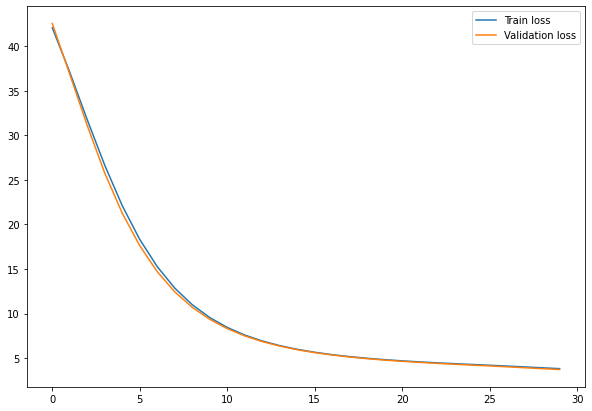

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [47]:
CER_arabic_val = get_per(data_loader_val_letters, cpc_model, character_classifier)
print('CER arabic:', CER_arabic_val)

N/A% (0 of 19) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (19 of 19) |########################| Elapsed Time: 0:03:21 Time:  0:03:21


Average PER 0.9522004517648994
CER arabic: 0.9522004517648994


In [49]:
path_test_data_cer = '/content/drive/My Drive/speech Recognition Data- Final project/data/Test'
data_test_cer, _ = findAllSeqs(path_test_data_cer, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_cer, data_test_cer, letters_labels)
data_loader_test_letters = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE, shuffle=True)

11it [00:00, 405.35it/s]

Saved cache file at /content/drive/My Drive/speech Recognition Data- Final project/data/Test/_seqs_cache.txt


Loaded 576 sequences in 22.08 seconds
maxSizeSeq : 174966
maxSizePhone : 81
minSizePhone : 11
Total size dataset 1.0665771875 hours


In [50]:
CER_arabic_test = get_per(data_loader_test_letters, cpc_model, character_classifier)
print('CER arabic:', CER_arabic_test) 

N/A% (0 of 72) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (72 of 72) |########################| Elapsed Time: 0:07:17 Time:  0:07:17


Average PER 0.9589153238064058
CER arabic: 0.9589153238064058
